In [172]:
from matplotlib import pyplot as plt
from dataset import CamyleonDataset
from pathlib import Path
import random
import numpy as np
# from augmentations import Augmentations
# from masking import MaskingGenerator
import torch
from model import Model, init_model
from run_inference import infer_slide, remove_noise
from monai.data import WSIReader
import cv2
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
preprocessed_data_file = Path("/home/espenbfo/Documents/projects/dinov2_wsi/camelyon.hdf5")

dataset = CamyleonDataset(preprocessed_data_file, is_train=False)
print(dataset.files)

{'masks': ['/home/espenbfo/datasets/camelyon/masks/patient_008_node_2_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_035_node_3_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_043_node_2_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_034_node_2_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_044_node_0_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_022_node_3_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_020_node_4_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_036_node_4_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_038_node_2_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_041_node_0_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_017_node_4_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_024_node_2_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_020_node_2_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_025_node_0_mask.tif', '/home/es

1
torch.Size([3, 224, 224])


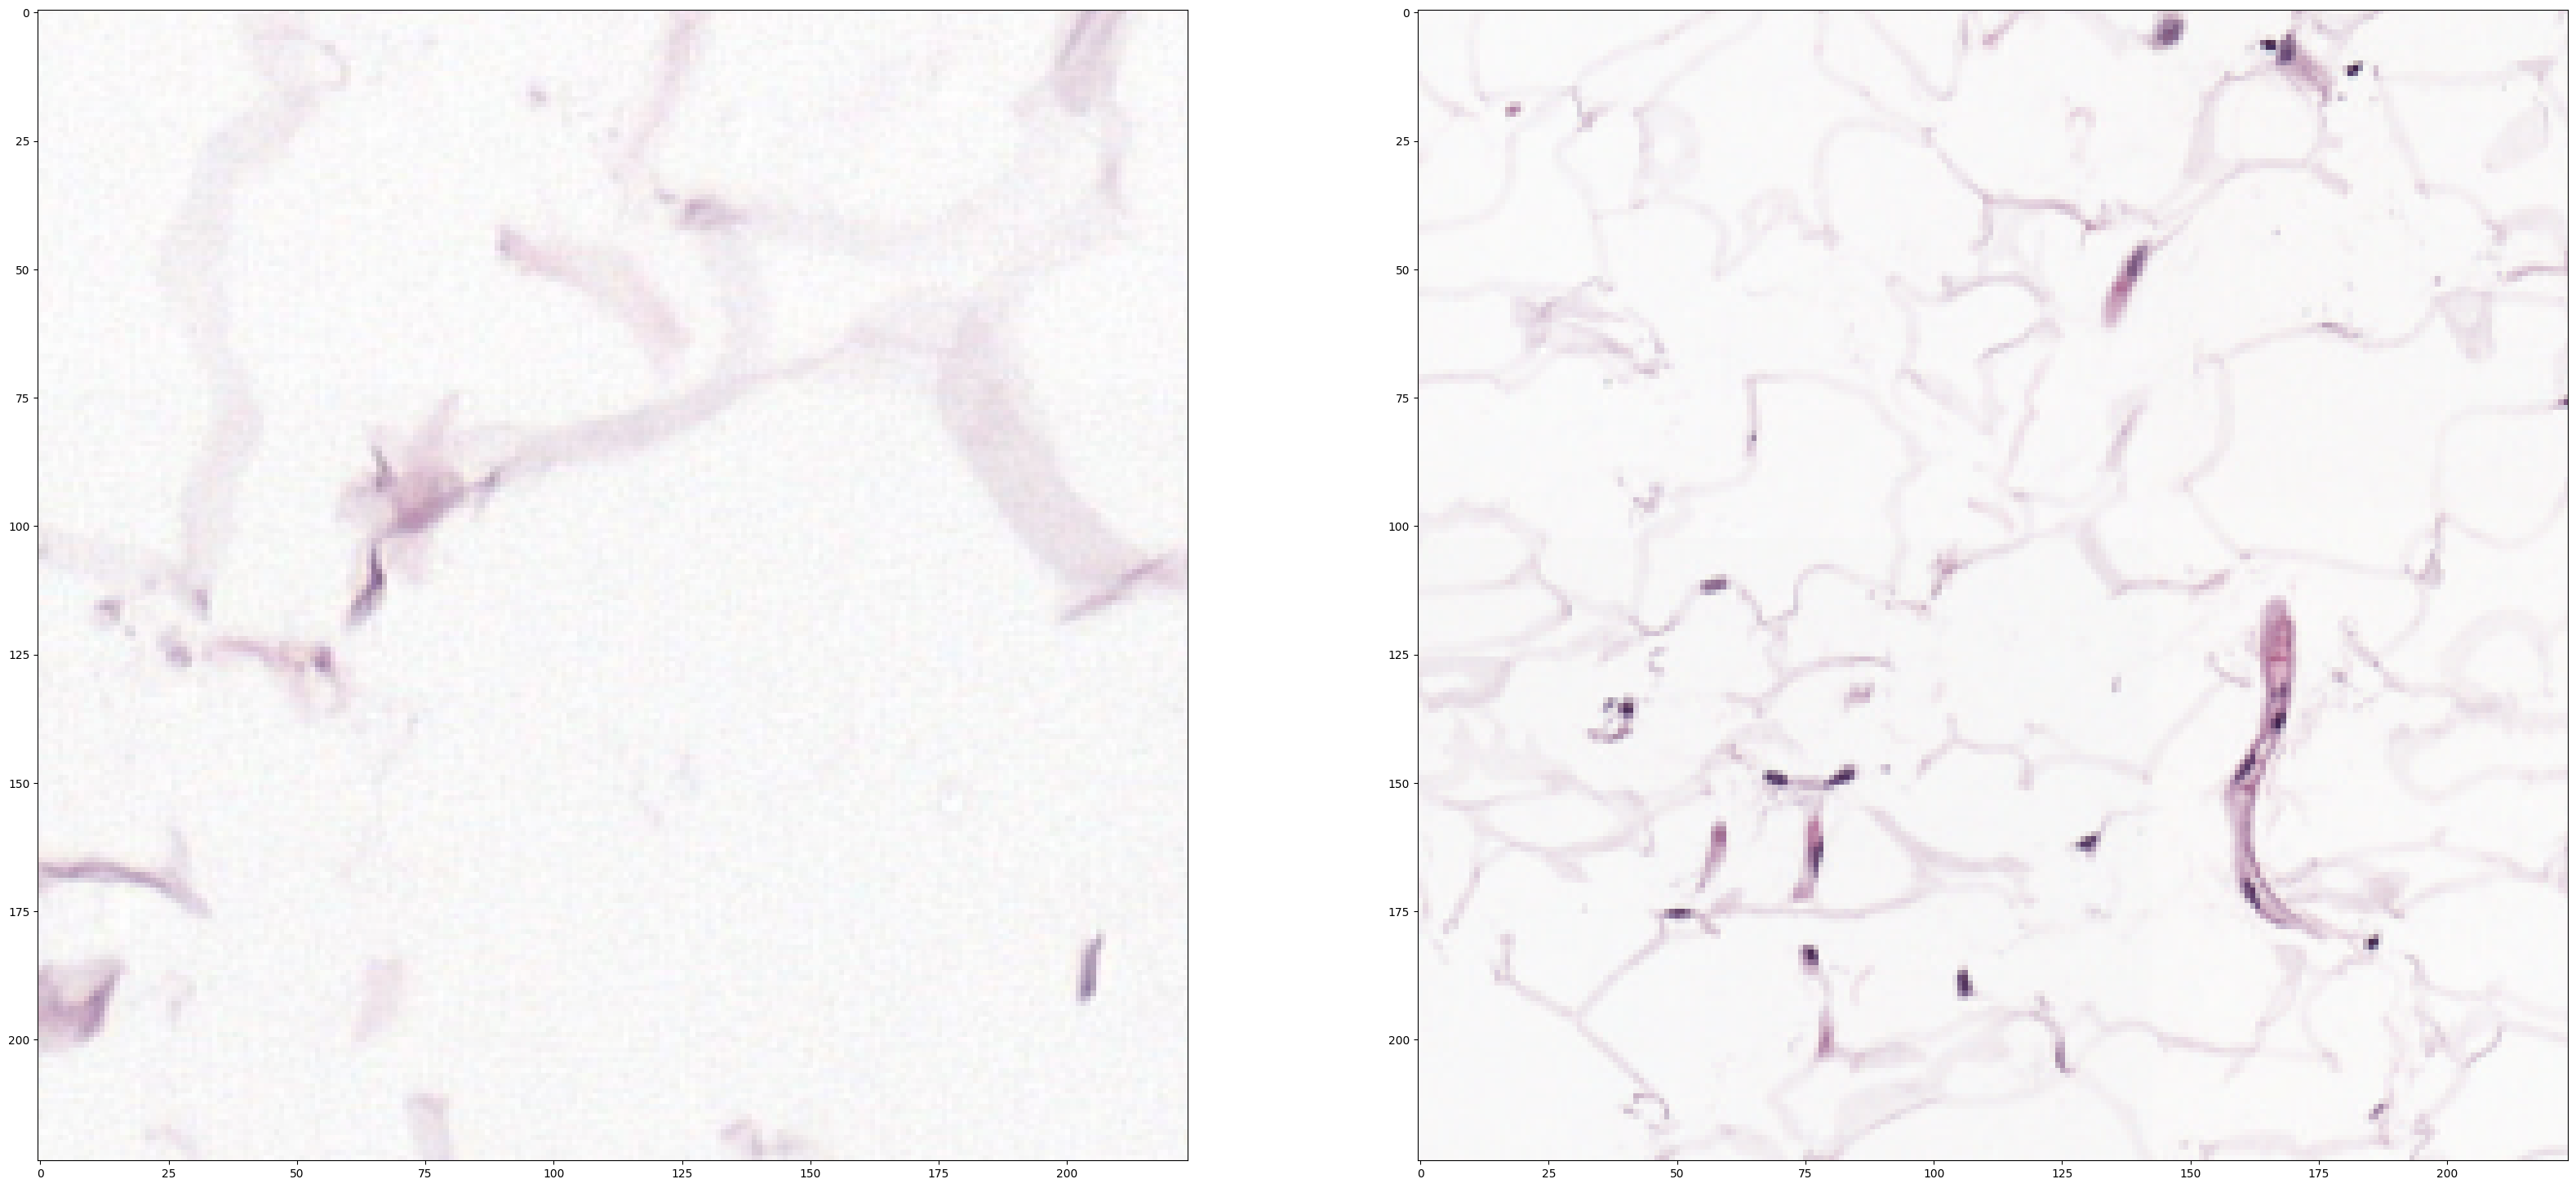

In [107]:
(image1, image2), label = dataset.__getitem__(2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(40, 20))

print(label)
print(image1.shape)
ax1.imshow(np.moveaxis(image1.numpy(), 0, 2))
ax2.imshow(np.moveaxis(image2.numpy(), 0, 2))


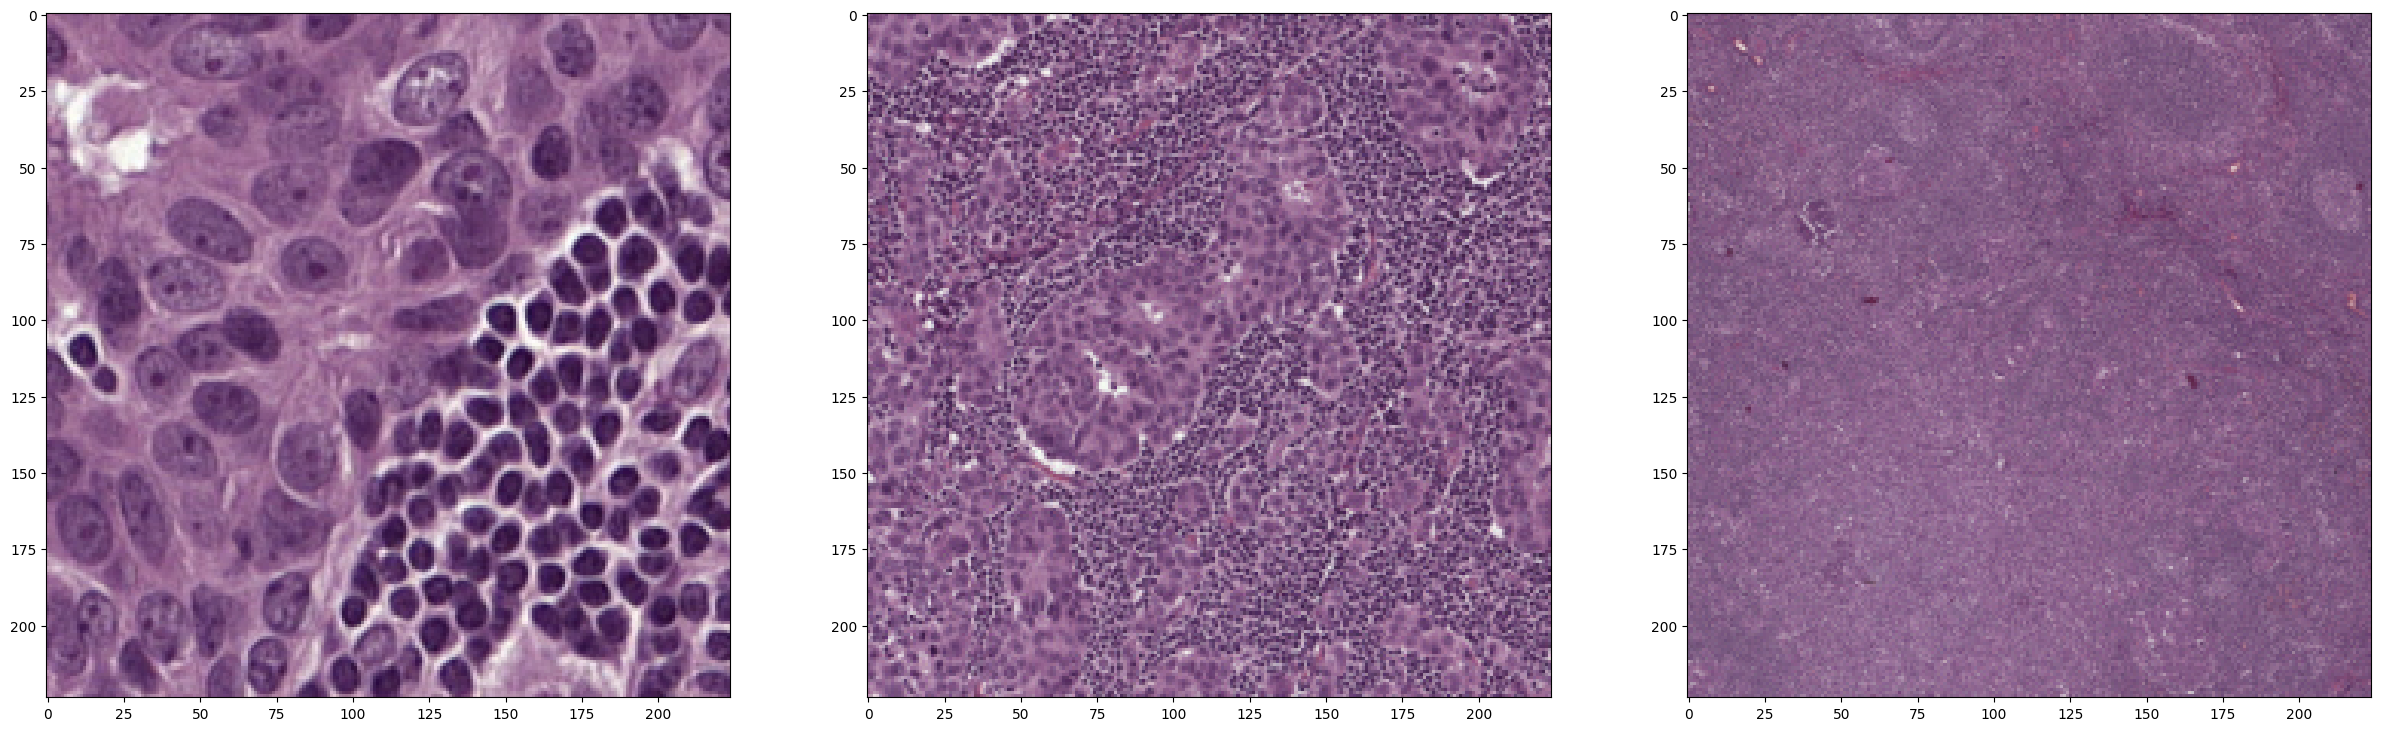

In [108]:
sizes = (100, 500, 2500)

label = 2
index, key = dataset.label_to_index[label][0]
images = dataset.retrieve_patch_with_label(2, index, key, sizes=sizes)

fig, axes = plt.subplots(1,len(sizes), figsize=(10*len(sizes), 10))

for i, ax in enumerate(axes):
    ax.imshow(np.moveaxis(images[i].numpy(), 0, 2))

In [109]:
model = init_model(2)
state_dict = torch.load("weights.pt")
model.load_state_dict(state_dict)

Embedding dimension: 768


<All keys matched successfully>

In [168]:
slide_id = 7
inference, ignored = infer_slide(dataset.files["images"][slide_id], 1, model.to("cuda"), distance_per_sample=1000/250)

  0%|          | 0/1173 [00:00<?, ?it/s]

  2%|▏         | 19/1173 [00:00<00:31, 36.52it/s, std: 0.000]/home/espenbfo/Documents/projects/dinov2_wsi/finetune/camelyon/run_inference.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  #label = 1 + 0.5 + pred[0][1]*0.5 - pred[0][0]*0.5
100%|██████████| 1173/1173 [00:34<00:00, 33.92it/s, std: 0.012]


0.0
1.0


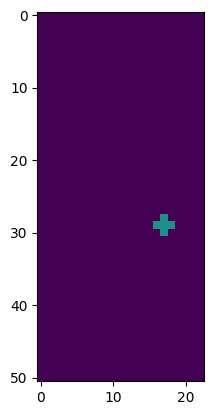

In [175]:
print(inference.min())
print(inference.max())

plt.imshow(remove_noise(inference), vmin=0, vmax=2)

/home/espenbfo/datasets/camelyon/masks/patient_036_node_4_mask.tif
/home/espenbfo/datasets/camelyon/images/patient_036_node_4.tif
[0 1]


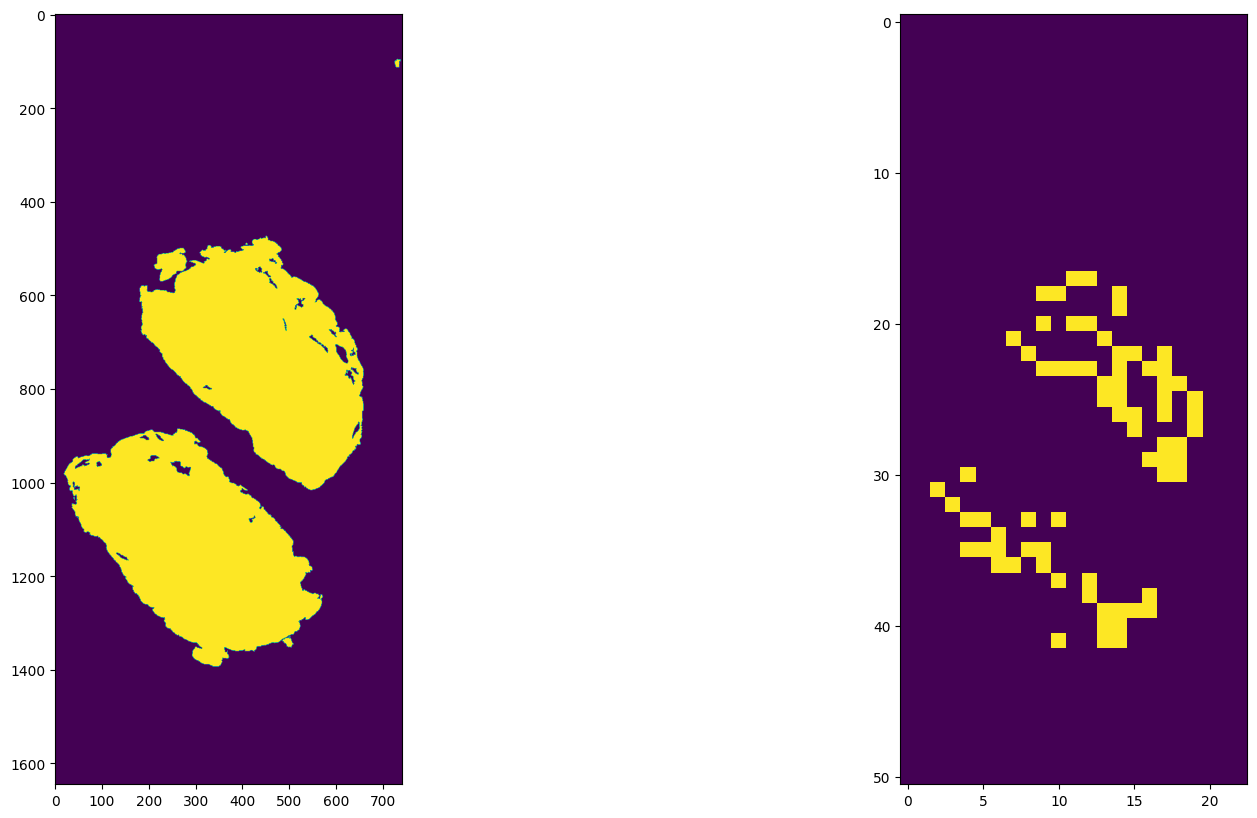

In [170]:
masked_file = dataset.files["masks"][slide_id]
print(masked_file)
print(dataset.files["images"][slide_id])

masked_reader = WSIReader(backend="tifffile")
masked_file = masked_reader.read(masked_file)
mask = masked_reader.get_data(masked_file, level=7, mode="Å")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
print(np.unique(mask[0]))
ax1.imshow(mask[0][0])
ax2.imshow(inference)

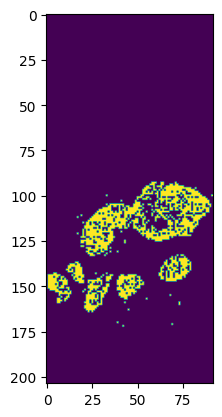

In [167]:
masked_resized = cv2.resize(mask[0][0], inference.shape[::-1])
plt.imshow((masked_resized==2)!=(inference==2))
